<h1>Deriving MHWs using a shifting baseline</h1>

**Dataset used here**: Global Ocean OSTIA Sea Surface Temperature and Sea Ice Reprocessed (OSTIA) (Dataset ID: METOFFICE-GLO-SST-L4-REP-OBS-SST)

*Worsfold, M.; Good, S.; Atkinson, C.; Embury, O. Presenting a Long-Term, Reprocessed Dataset of Global Sea Surface Temperature Produced Using the OSTIA System. Remote Sens. 2024, 16, 3358. https://doi.org/10.3390/rs16183358*

Available at: https://data.marine.copernicus.eu/product/SST_GLO_SST_L4_REP_OBSERVATIONS_010_011/services

In [ ]:
### Imports 

# ! pip install copernicusmarine
import copernicusmarine
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import math
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter
from scipy.stats import circmean
from collections import deque

In [ ]:
### Remotely login and access the data from CMEMS

copernicusmarine.login()
datasetID = 'METOFFICE-GLO-SST-L4-REP-OBS-SST'
DS = copernicusmarine.open_dataset(dataset_id = datasetID)

In [ ]:
### Crop to area of interest - choose coordinates

lon_min = -44
lon_max = -30
lat_min = -59
lat_max = -49

lon = slice(lon_min, lon_max)   
lat = slice(lat_min, lon_max) 
cropped_DS = DS.analysed_sst.sel(longitude = lon, latitude = lat)

raw_data = cropped_DS.to_dataframe()

In [3]:
### DELETE !!!!!!!!!!!!!!!!!!!!!!!!

rawECB = pd.read_pickle('C:/Users/annas/OneDrive/Cambridge/WORK/BAS/PYTHON/ECB_raw.pkl')
raw_data = rawECB.reset_index()

In [5]:
### Organise spatially-averaged SST into dataframe for all years 1982-2021 (columns = years, rows = day of year)

year_start = 1982
year_end   = 2022

# Spatially average every day
grouped_DoY = raw_data.groupby('time')
average_day_sst = grouped_DoY.mean()
average_day_sst = average_day_sst.reset_index()

# Remove 29th February and create new dataframe
sst_groupby_yr = {}
for i in range(year_start, year_end): 
    t_evolution = average_day_sst[(average_day_sst['time'] >= f"{i}-01-01") & (average_day_sst['time'] <= f"{i}-12-31")]
    t_evolution = t_evolution[t_evolution['time'] != f"{i}-02-29"]
    sst_groupby_yr[f'sst_{i}'] = t_evolution['analysed_sst'].reset_index()['analysed_sst']

year_col_sst = pd.DataFrame.from_dict(sst_groupby_yr) 

year_col_sst.head(3)

,sst_1982,sst_1983,sst_1984,sst_1985,sst_1986,sst_1987,sst_1988,sst_1989,sst_1990,sst_1991,...,sst_2012,sst_2013,sst_2014,sst_2015,sst_2016,sst_2017,sst_2018,sst_2019,sst_2020,sst_2021
0,275.509388,275.116746,275.590762,275.144941,275.949796,274.948702,274.901659,276.170681,276.384196,275.552101,...,275.244208,275.015419,275.581263,275.659493,275.159563,275.136618,276.094499,275.542823,275.753661,275.582345
1,275.479889,275.205151,275.650879,275.177072,275.814150,274.977561,274.999319,276.180727,275.947596,275.560599,...,275.268085,275.111717,275.509214,275.648771,275.410611,274.998702,276.165500,275.599586,275.782310,275.661135
2,275.533451,275.257666,275.686955,274.931624,276.214313,274.955721,274.932078,276.099912,275.851903,275.739540,...,275.444196,275.163940,275.531519,275.599016,275.473009,274.976315,276.174907,275.657992,275.754639,275.832229


**Deriving the Shifting Baseline & Finding Anomalies**

* Loop over each year (2002-2021) and derive the background climatology for the 20 years preceeding that year. This is added to the <span style="color:#FF6833">**bg_climat_dict**</style>. 
* In the same loop, the 90th percentile is also found so that anomalies for that year can be found. These are added to the <span style="color:#FF6833">**anoms_dict**</style>.
* Both dictionaries can then be converted to dataframes. 

In [ ]:
bg_climat_dict = {} # Dictionary to store each derived background climatology for each year
anoms_dict = {} # Dictionary to store each year's days that exceed the 90th percentile (and how much by)

for i in range(0, 20):

    times = pd.date_range(f'{1982+i}-01-01', f'{1982+i+19}-12-31', freq='D')
    raw_data['time'] = pd.to_datetime(raw_data['time'])
    avgs = raw_data.groupby('time')['analysed_sst'].mean().reindex(times, fill_value=None)

    dict = {'date': times, 'avg_t': avgs}  
    bg_timeseries = pd.DataFrame(dict)

    # Remove 29th February from averaged timeseries
    bg_timeseries['year'] = bg_timeseries['date'].dt.year
    bg_timeseries['month'] = bg_timeseries['date'].dt.month
    bg_timeseries['day'] = bg_timeseries['date'].dt.day
    bg_timeseries = bg_timeseries.loc[~((bg_timeseries['month'] == 2) & (bg_timeseries['day'] == 29))]

    # Remove 29th February from list of dates over the 20 years
    day = pd.date_range(f'{1982+i}-01-01', f'{1982+i+19}-12-31', freq='D')
    day_no_feb29 = day[~((day.month == 2) & (day.day == 29))]

    # Apply smoothing filter
    sigma = 30
    smoothed_avgs = gaussian_filter(bg_timeseries['avg_t'].to_list(), sigma=sigma)

    # Create new dataframe of dates and smoothed averages 
    dict2 = {'date': day_no_feb29, 'avg_t': smoothed_avgs} 
    smooth_bg_timeseries = pd.DataFrame(dict2)
    smooth_bg_timeseries['year'] = smooth_bg_timeseries['date'].dt.year

    ###

    # Split into columns for each year
    year = np.arange(1982+i, 1982+i+20)
    dict3 = {}
    for j in range(len(year)):
        sst = smooth_bg_timeseries.query(f"year == {year[j]}")['avg_t'].values
        dict3[f'sst_{year[j]}'] = sst
    bg = pd.DataFrame(dict3)

    # Average across each calander day to get climatology and 90th percentile
    bg['mean'] = bg.mean(axis=1)
    bg['Q90'] = bg.apply(lambda row: np.percentile(row.drop('mean'), 90), axis=1)

    # Add to bg_climat_dict dictionary
    bg_climat_dict[f'bg_{1982+i+20}'] = bg['mean'] - 273.15

    ###

    # Calculate difference between raw SST and climatology 
    m = 1982+20+i       # Year in interest

    sstdiff_gb_yr = {}
    diff = year_col_sst[f'sst_{m}'] - bg['mean']
    sstdiff_gb_yr[f'diff_{m}'] = diff

    difference = pd.DataFrame.from_dict(sstdiff_gb_yr)      # Create new dataframe for diff,
    difference['mean'] = bg['mean'] - 273.15                # background climatology
    difference['Q90'] = bg['Q90'] - bg['mean']              # and the difference between climatology and 90th percentile

    ###

    # Find the difference between the raw SST and the 90th percentile 
    # If there is a positive difference, the raw SST exceeds the 90th percentile
    # The values on these days are kept, others are set to NaN
    
    std_diff = []
    for i in range(len(difference['Q90'])):
        if difference[f'diff_{m}'].iloc[i] >= 0:
            diff = difference[f'diff_{m}'].iloc[i] - difference['Q90'].iloc[i]
            if diff > 0:
                std_diff.append(diff)
            else:
                std_diff.append(np.nan)
        else:
            diff = - difference[f'diff_{m}'].iloc[i] - difference['Q90'].iloc[i]
            if diff > 0:
                std_diff.append(-diff)
            else:
                std_diff.append(np.nan)
    anoms_dict[f'std_diff{m}'] = std_diff 

times = pd.date_range('1982-01-01', '1982-12-31', freq='D')  
dict['date'] = times

In [ ]:
# Convert to dataframe

bg_climats = pd.DataFrame(bg_climat_dict)
bg_climats.head(3)

,bg_2002,bg_2003,bg_2004,bg_2005,bg_2006,bg_2007,bg_2008,bg_2009,bg_2010,bg_2011,bg_2012,bg_2013,bg_2014,bg_2015,bg_2016,bg_2017,bg_2018,bg_2019,bg_2020,bg_2021
0,2.084878,2.081041,2.062324,2.057492,2.067192,2.047910,2.086475,2.098554,2.089047,2.067318,2.099745,2.130693,2.132566,2.136129,2.166754,2.189837,2.153964,2.236966,2.223717,2.254281
1,2.109395,2.106008,2.087319,2.081730,2.091696,2.073031,2.111549,2.123457,2.114423,2.092414,2.124590,2.155615,2.157154,2.160253,2.190657,2.213154,2.177098,2.259800,2.246527,2.277190
2,2.133772,2.130810,2.112155,2.105804,2.116022,2.097976,2.136458,2.148182,2.139633,2.117338,2.149252,2.180376,2.181585,2.184224,2.214409,2.236298,2.200071,2.282466,2.269160,2.299912


In [28]:
# Convert to dataframe

anoms = pd.DataFrame(anoms_dict)
anoms.head(3)

,std_diff2002,std_diff2003,std_diff2004,std_diff2005,std_diff2006,std_diff2007,std_diff2008,std_diff2009,std_diff2010,std_diff2011,std_diff2012,std_diff2013,std_diff2014,std_diff2015,std_diff2016,std_diff2017,std_diff2018,std_diff2019,std_diff2020,std_diff2021
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007607,NaN,0.818538,NaN,NaN,NaN,0.004289,NaN,NaN,0.439295,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.040334,NaN,0.852829,NaN,NaN,NaN,NaN,NaN,NaN,0.483271,NaN,0.019666,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.076515,NaN,0.946652,NaN,NaN,NaN,NaN,NaN,-0.004748,0.465849,NaN,NaN,0.041586


**Defining MHWs from anomalies**

In [46]:
### Identify the MHW events per year

# Go through anoms dataframe and record lengths of each period that exceeds (length of consecutive cells with values in)
start_d = []
end_d = []

years = np.arange(2002, 2022)

for i in range(2002, 2022):
    yrlist = list(anoms[f'std_diff{i}'])

    yrlistp = deque([np.nan if x < 0 else x for x in yrlist])
    yrlistp.appendleft(np.nan)

    indvals = []
    for m in range(len(yrlistp)):
        if np.isnan(yrlistp[m-1]):
            if not np.isnan(yrlistp[m]):
                indvals.append(m)

    start_day = []
    end_day = []

    # Only count events that are 5 days or longer
    # Record the start and end dates of each event

    for k in range(len(indvals)):
        arr_here = []
        for j in range(len(yrlistp)-indvals[k]):
            if not np.isnan(yrlistp[indvals[k]+j]):
                arr_here.append(yrlistp[indvals[k]+j])
            if np.isnan(yrlistp[indvals[k]+j]):
                break
        if len(arr_here) > 4:
            start_day.append(indvals[k]-1)
            end_day.append(indvals[k]+len(arr_here)-1)
    start_d.append(start_day)
    end_d.append(end_day)

# Create dataframe, each row is a year. 
# The columns startdate and enddate hold lists of each event within each year
dict = {'year': years, 'startdate': start_d, 'enddate': end_d}
start_end = pd.DataFrame.from_dict(dict)

###

# Find the break between each event and merge those that are < 5 days apart
breaks = []
for i in range(len(years)):
    starts = start_end.loc[start_end['year'] == years[i], 'startdate'].values[0]
    ends = start_end.loc[start_end['year'] == years[i], 'enddate'].values[0]
    br = []
    for j in range(len(starts)-1):
        diff = starts[j+1] - ends[j]
        br.append(diff)
    breaks.append(br)

start_end['breaks'] = breaks

new_start = []
new_end = []

for m in range(len(years)):
    Breaks = start_end.loc[start_end['year'] == years[m], 'breaks'].values[0]
    starts = start_end.loc[start_end['year'] == years[m], 'startdate'].values[0]
    ends = start_end.loc[start_end['year'] == years[m], 'enddate'].values[0]

    for k in range(len(Breaks)):
        if Breaks[k] < 5:
            ends[k] = np.nan
            starts[k+1] = np.nan

    new_start.append([x for x in starts if not (isinstance(x, float) and math.isnan(x))])
    new_end.append([x for x in ends if not (isinstance(x, float) and math.isnan(x))])


dict = {}
dict['year'] = start_end['year']
dict['starts'] = new_start
dict['ends'] = new_end

# Create new dataframe
MHWevents = pd.DataFrame.from_dict(dict)

In [47]:
### Find the intensities etc. of each event

all_max_int = []
all_avg_int = []
all_duration = []
all_peaks = []
year_here = []

for i in range(len(years)):
    max_i = []
    avg_i = []
    dur = []
    year_Here = []
    peak_day = []
    for j in range(len(MHWevents.loc[MHWevents['year'] == years[i], 'starts'].values[0])):
        temp_excess = []
        start = MHWevents.loc[MHWevents['year'] == years[i], 'starts'].values[0][j]
        end = MHWevents.loc[MHWevents['year'] == years[i], 'ends'].values[0][j]
        for m in range(start, end):
            temp_excess.append(anoms[f'std_diff{years[i]}'].iloc[m])
        max_i.append(np.nanmax(temp_excess))
        avg_i.append(np.nanmean(temp_excess))
        dur.append(len(temp_excess))
        peak_day.append(np.nanargmax(temp_excess)+MHWevents.loc[MHWevents['year'] == years[i], 'starts'].values[0][j])
        year_Here.append(years[i])

    all_max_int.append(max_i)
    all_avg_int.append(avg_i)
    all_duration.append(dur)
    all_peaks.append(peak_day)
    year_here.append(year_Here)

MHWevents['max_i'] = all_max_int
MHWevents['avg_i'] = all_avg_int
MHWevents['duration'] = all_duration
MHWevents['peak_day'] = all_peaks
MHWevents['year_here'] = year_here

MHWevents.head(3)

,year,starts,ends,max_i,avg_i,duration,peak_day,year_here
0,2002,[11],[76],[0.7664577289825161],[0.3328092246364524],[65],[28],[2002]
1,2003,"[31, 45, 333]","[38, 61, 361]","[0.17501416338097897, 0.2632234867156171, 0.67...","[0.09323492762789394, 0.1245038417453744, 0.28...","[7, 16, 28]","[34, 51, 356]","[2003, 2003, 2003]"
2,2004,[325],[343],[0.3220879147124265],[0.1327795895096691],[18],[335],[2004]


**Categorise events** Using *Hobday et al, 2018* categorisation scheme for intensity

In [48]:
### Defining event intensities

# Multiples of 90th percentile
difference['Q902'] = difference['Q90']*2
difference['Q903'] = difference['Q90']*3
difference['Q904'] = difference['Q90']*4

# Find which range the peak intensity lies in
peak_intensity = []

for i in range(len(years)):
    peak_here = []
    for j in range(len(MHWevents['peak_day'].iloc[i])):
        peak_ints = (MHWevents['max_i']).iloc[i][j]

        peak_int = (MHWevents['peak_day']).iloc[i][j]
        q901 = difference['Q90'].iloc[peak_int]
        q902 = difference['Q902'].iloc[peak_int]
        q903 = difference['Q903'].iloc[peak_int]
        q904 = difference['Q904'].iloc[peak_int]

        if 0 <= peak_ints < q901:
            peak_here.append('Moderate')
        if q901 <= peak_ints < q902:
            peak_here.append('Strong')
        if q902 <= peak_ints < q903:
            peak_here.append('Severe')
        if q903 <= peak_ints:
            peak_here.append('Extreme')

    peak_intensity.append(peak_here)

MHWevents['intensity_cat'] = peak_intensity

**Plotting Fig.10**
*MHW events displayed as bars where length equates to the event’s duration*

(array([  0.,  50., 100., 150., 200., 250., 300., 350., 400.]),
 [Text(0.0, 0, '0'),
  Text(50.0, 0, '50'),
  Text(100.0, 0, '100'),
  Text(150.0, 0, '150'),
  Text(200.0, 0, '200'),
  Text(250.0, 0, '250'),
  Text(300.0, 0, '300'),
  Text(350.0, 0, '350'),
  Text(400.0, 0, '400')])

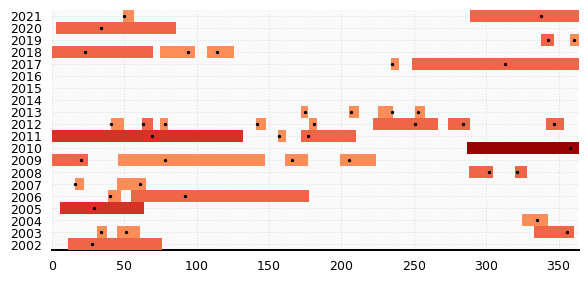

In [ ]:
# Intensity colours
colors = ['#990000','#d73027','#ef6548', '#fc8d59']

# Convert to lists for plotting
peakdaypW = [item for sublist in MHWevents['peak_day'] for item in sublist]
yrW = np.array([item for sublist in MHWevents['year_here'] for item in sublist])
startday = np.array([item for sublist in MHWevents['starts'] for item in sublist])
duration = np.array([item for sublist in MHWevents['duration'] for item in sublist])

###

plt.figure(figsize=(6,3))

ax = plt.gca()
ax.set_facecolor('#FAFAFA')
ax.spines[['top', 'right', 'left']].set_visible(False)
ax.spines[['bottom']].set_linewidth(1.4)

plt.yticks(years, fontsize=9)
plt.xticks(fontsize=9)
plt.tick_params(left = False)
plt.tick_params(bottom = False)
plt.grid( linestyle='dotted', color='#ccc', zorder=1, alpha=0.5)
plt.xlim(0,364)
plt.ylim(2001.5, 2021.5)

# Plot each event as a shaded rectangle
for i in range(0,20):
    y = years[i]
    starts = MHWevents['starts'].loc[i]
    dur = MHWevents['duration'].loc[i]
    inten = MHWevents['avg_i'].loc[i]

    for m in range(len(dur)):
        y_min = y - 0.5
        x_min = starts[m]
        y_len = 1
        x_len = dur[m]
        intensity = inten[m]

        if MHWevents['intensity_cat'].loc[i][m] == 'Moderate':
            colour = colors[3]
        if MHWevents['intensity_cat'].loc[i][m] == 'Strong':
            colour = colors[2]
        if MHWevents['intensity_cat'].loc[i][m] == 'Severe':
            colour = colors[1]
        if MHWevents['intensity_cat'].loc[i][m] == 'Extreme':
            colour = colors[0]

        ax.add_patch(Rectangle((x_min, y_min), x_len, y_len, fc =colour,lw = 0, zorder=5))

# Peak days 
plt.scatter(peakdaypW, yrW, c='k', s=2, zorder=10)

plt.tight_layout()
plt.show()

**Plotting Fig.17**
*Shifting-baseline background climatologies for 2002-2021*

In [43]:
# Gradient colours for each year

colors = ["#041F3F", "#062E5A", "#0A4174", "#104E8A", "#175CA0",
        "#1F6BB5", "#2A7CCC", "#3C78C7", "#5073C3", "#636EBD",
        "#7769B4", "#8B64AA", "#A65F95", "#C05A7C", "#E75C5C",
        "#D94848", "#C73737", "#B82C2C", "#A12323", "#8B1A1A"]

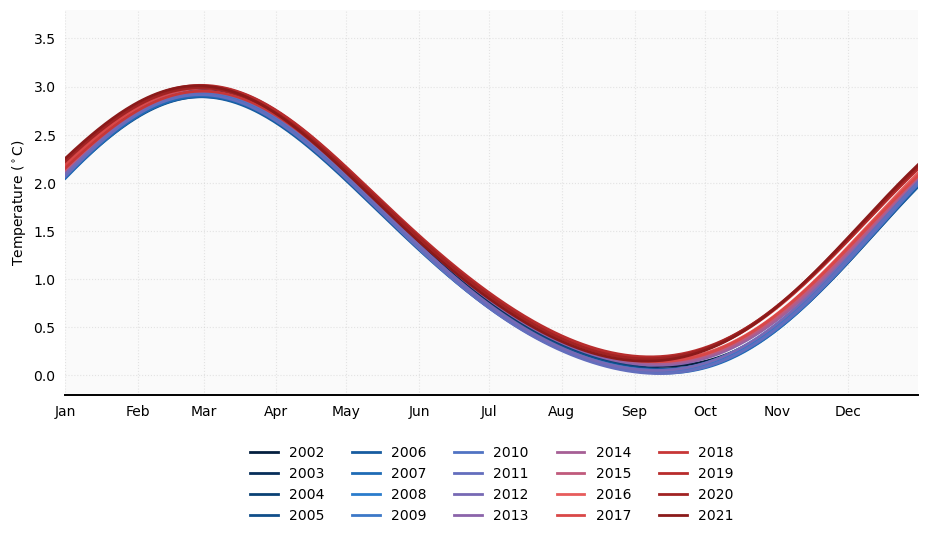

In [45]:
times = pd.date_range('1990-01-01', '1990-12-31', freq='D')

plt.figure(figsize=(11, 5))

ax= plt.gca()
ax.set_facecolor('#FAFAFA')
ax.spines[['top', 'right', 'left']].set_visible(False)
ax.spines[['bottom']].set_linewidth(1.4)

plt.ylabel('Temperature ($^\circ$C)')
plt.grid(linestyle='dotted', color='#ccc', zorder=1, alpha=0.5)
plt.tick_params(left = False)
plt.tick_params(bottom = False)

plt.ylim(-0.2, 3.8)
plt.xlim(pd.to_datetime('1990-01-01'), pd.to_datetime('1990-12-31'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

for i in range(2002, 2022):
    plt.plot(times, bg_climats[f'bg_{i}'], color=colors[i-2002], linewidth=2, label=f'{i}')

plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=5, frameon=False)

plt.show()

**References**

Hobday A.J., Oliver E.C.J., Sen Gupta A., Benthuysen J.A., Burrows M.T., et al. (2018). *Categorizing and naming marine heatwaves*. Oceanography 31(2):162–73